## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from random import sample 
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D


from keras.applications.resnet import ResNet50 

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [15]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33286,00008727_023.png,Nodule,23,8727,55,M,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00008727_023.png
51300,00012958_000.png,No Finding,0,12958,74,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012958_000.png
54138,00013620_020.png,Effusion,20,13620,62,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00013620_020.png


In [16]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
findings=set()
for x in all_xray_df['Finding Labels']:
    for y in x.split('|'):
        if y not in findings and y!= 'No Finding':
            findings.add(y)
findings

for f in findings:
    all_xray_df[f] = all_xray_df['Finding Labels'].map(lambda x:1 if f in x else 0)
# Todo


In [17]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x:'pos' if x else 'neg')
# Todo


## Create your training and testing data:

In [18]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, valid_data = train_test_split(df, test_size = 0.1, stratify = df['pneumonia_class'])
    p_inds = train_data[train_data.pneumonia_class=='pos'].index.tolist()
    np_inds = train_data[train_data.pneumonia_class=='neg'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    return train_data, valid_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [19]:
def my_image_augmentation(h_flip=False ,rot= 0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = h_flip, 
                              vertical_flip = False, 
                              height_shift_range = 0.4, 
                              width_shift_range = 9.6, 
                              rotation_range = rot, 
                              shear_range = 0.5 ,
                              zoom_range= 0.5
                        )
    
    return my_idg


def make_train_gen(train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(h_flip=True, rot=9)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224, 224) , 
                                          batch_size = 9
                                          )
     # Todo

    return train_gen


def make_val_gen(val_data):
    
    my_val_idg = my_image_augmentation()

    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224, 224), 
                                              batch_size = 9) 
    
    # Todo
    return val_gen

In [20]:
train_data, val_data = create_splits(all_xray_df)
train_gen=make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2576 validated image filenames belonging to 2 classes.
Found 11212 validated image filenames belonging to 2 classes.


In [21]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

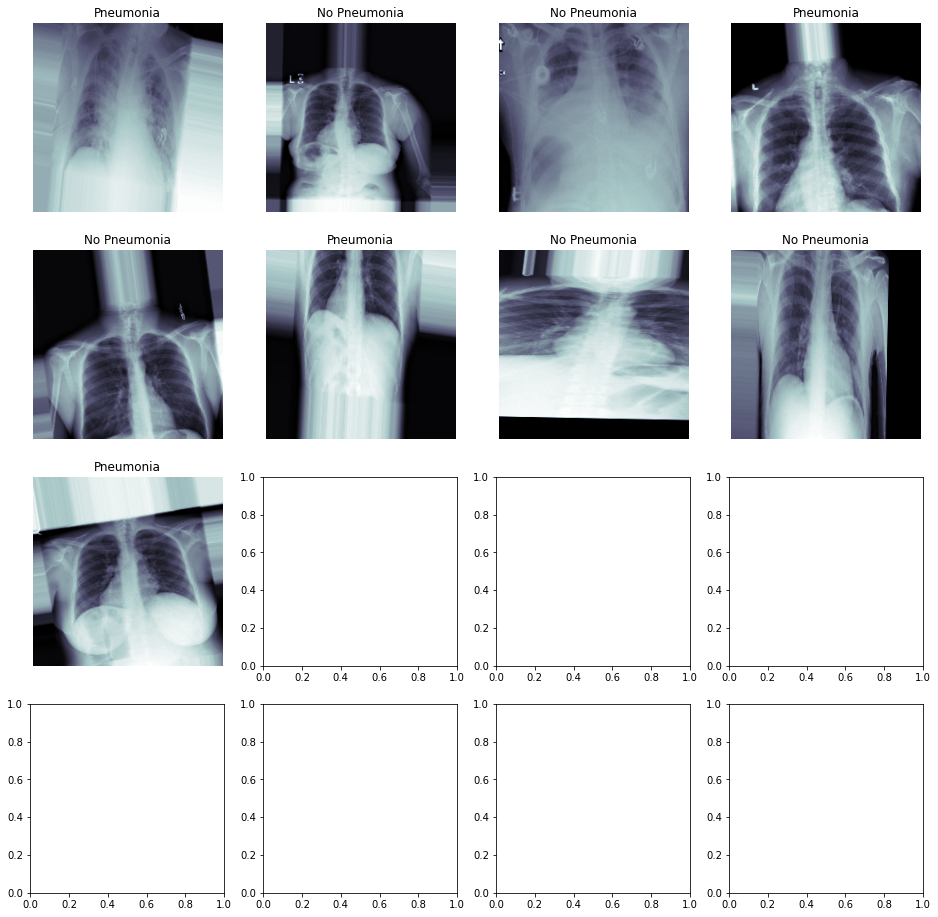

In [22]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [23]:
def load_pretrained_model(lay_of_interest='block5_pool'):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [27]:
def build_my_model(pretrained):
    for layer in pretrained.layers[0:17]:
        layer.trainable = False
    
    new_model = Sequential()
    new_model.add(pretrained)
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    new_model.add(Flatten())
    new_model.add(Dropout(0.5))

    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))

    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))

    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [28]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [31]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

pretrained= load_pretrained_model()
my_model = build_my_model(pretrained)

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                        validation_data = (valX, valY), 
                        epochs = 5, 
                        callbacks = callbacks_list)

Epoch 1/5
287/287 [==============================] - 80s 278ms/step - loss: 0.7708 - binary_accuracy: 0.5283 - val_loss: 0.6295 - val_binary_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.62954, saving model to xray_class_my_model.best.hdf5
Epoch 2/5
287/287 [==============================] - 70s 243ms/step - loss: 0.7144 - binary_accuracy: 0.5171 - val_loss: 0.6712 - val_binary_accuracy: 0.7778

Epoch 00002: val_loss did not improve from 0.62954
Epoch 3/5
287/287 [==============================] - 70s 243ms/step - loss: 0.6999 - binary_accuracy: 0.5171 - val_loss: 0.5927 - val_binary_accuracy: 0.7778

Epoch 00003: val_loss improved from 0.62954 to 0.59265, saving model to xray_class_my_model.best.hdf5
Epoch 4/5
287/287 [==============================] - 69s 241ms/step - loss: 0.6942 - binary_accuracy: 0.5415 - val_loss: 0.7411 - val_binary_accuracy: 0.1111

Epoch 00004: val_loss did not improve from 0.59265
Epoch 5/5
287/287 [==============================] - 70s 243ms

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)